In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp  "/content/drive/My Drive/Academics/CS/AML/Project/Data/preprocessed_full.csv" .

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
data_full = pd.read_csv("preprocessed_full.csv")
#concert to string from object
data_full["Text"]= data_full["Text"].astype("str")

## Step 2.5: Train / Validate / Test Split
* 68% training set, 17% validation set, 15% test set

In [ ]:
from sklearn.model_selection import train_test_split
X = data_full[["Text"]].values
y = data_full[["IsHate"]].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape, X_validate.shape, X_test.shape)


(32403, 1) (8101, 1) (7148, 1)


## One hot-encoding from character level

In [ ]:
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import sys

np.set_printoptions(threshold=sys.maxsize)
tokenizer = Tokenizer(char_level=True)

tokenizer.fit_on_texts(X_train.ravel())
sequence_of_int_train = tokenizer.texts_to_sequences(X_train.ravel())
sequence_of_int_validate = tokenizer.texts_to_sequences(X_validate.ravel())
max_length = max(map(len, sequence_of_int_train))

X_train = keras.preprocessing.sequence.pad_sequences(sequence_of_int_train, maxlen=max_length)
X_validate = keras.preprocessing.sequence.pad_sequences(sequence_of_int_validate, maxlen=max_length)

X_train_prepare = np.array(X_train)
X_validate_prepare = np.array(X_validate)

y_train = y_train.astype('int32') 
y_validate = y_validate.astype('int32') 
print(X_train_prepare.shape)

(32403, 586)


## Setting up and training LSTM

In [ ]:
## create f1 score metrics
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, Precision, Recall
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = Precision(thresholds=0.5)
        self.recall_fn = Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

### a different structured model

In [ ]:

# model = tf.keras.Sequential([
#     # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
#     tf.keras.layers.Embedding(len(tokenizer.index_word) + 1, embedding_dim),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#     # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     # use ReLU in place of tanh function since they are very good alternatives of each other.
#     tf.keras.layers.Dense(embedding_dim, activation='relu'),

#     # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
# model.summary()
# optimizer = keras.optimizers.Adam(lr=0.01)

# model.compile(optimizer=optimizer, loss="binary_crossentropy",
#               metrics=[F1_Score()])

# model.build(input_shape=X_train_prepare.shape)
# model.summary()

# history = model.fit(x=X_train_prepare, y=y_train.ravel(), epochs=25, shuffle=True,
#           batch_size=25, validation_data=(X_validate_prepare, y_validate.ravel()))


## Tune parameter on hidden nodes number

In [ ]:
def tune_hidden_node(node_col):
  #last epoch performance
  performance_train = []
  performance_validate = []
  
  embedding_dim = 4

  # Create the model
  for j in node_col:
    model = keras.Sequential()

    model.add(layers.Embedding(len(tokenizer.index_word) + 1, embedding_dim))


    model.add(layers.LSTM(j, activation="tanh",
                          return_sequences=True, dropout=.2))

    model.add(layers.LSTM(j, activation="tanh",
                          return_sequences=False, dropout=.2))

    model.add(layers.Dense(1, activation="sigmoid"))

    optimizer = keras.optimizers.Adam(lr=0.01)

    model.compile(optimizer=optimizer, loss="binary_crossentropy",
                  metrics=[F1_Score()])

    model.build(input_shape=X_train_prepare.shape)
    model.summary()
    tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

    history = model.fit(x=X_train_prepare, y=y_train, epochs=25, shuffle=True,
            batch_size=25, verbose = 2, validation_data=(X_validate_prepare, y_validate.ravel()))
    print("Last epoch training F1-score: %s"%history.history['f1_score'][-1])
    print("Last epoch validating F1-score: %s"%history.history['val_f1_score'][-1])
    performance_train.append(history.history['f1_score'][-1])
    performance_validate.append(history.history['val_f1_score'][-1])
  return performance_train, performance_validate



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           156       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          15600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 44,857
Trainable params: 44,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1297/1297 - 278s - loss: 0.6040 - f1_score: 0.6514 - val_loss: 0.5283 - val_f1_score: 0.6669
Epoch 2/25
1297/1297 - 276s - loss: 0.5131 - f1_score: 0.7012 - val_loss: 0.4982 - val_f1_score: 0.7039
Epoch 3/25
1297/1297 - 276s - loss: 0.4783

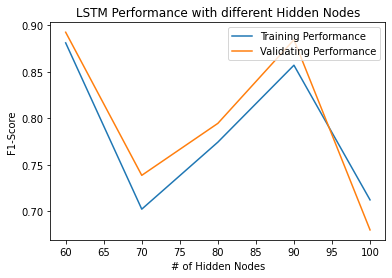

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
node_col = [10*i for i in range(6,11)]
performance_train, performance_validate = tune_hidden_node(node_col)
plt.plot(node_col,performance_train, label = "Training Performance" )
plt.plot(node_col, performance_validate, label = "Validating Performance")
plt.xlabel("# of Hidden Nodes")
plt.ylabel("F1-Score")
plt.title("LSTM Performance with different Hidden Nodes")
plt.legend()
plt.show()

## tune layers of LSTM

In [ ]:
## use 60 hidden nodes, try 1 layer, 2 layer => 5 layer LSTM network
def tune_hidden_layer(layer_col, hidden_node):
  #last epoch performance
  performance_train = []
  performance_validate = []
  
  embedding_dim = 4

  # Create the model
  for j in layer_col:
    model = keras.Sequential()

    model.add(layers.Embedding(len(tokenizer.index_word) + 1, embedding_dim))

    for l in range(j-1):

      model.add(layers.LSTM(hidden_node, activation="tanh",
                            return_sequences=True, dropout=.2))
   
    model.add(layers.LSTM(hidden_node, activation="tanh",
                          return_sequences=False, dropout=.2))
   

    model.add(layers.Dense(1, activation="sigmoid"))

    optimizer = keras.optimizers.Adam(lr=0.01)

    model.compile(optimizer=optimizer, loss="binary_crossentropy",
                  metrics=[F1_Score()])

    model.build(input_shape=X_train_prepare.shape)
    model.summary()
    tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

    history = model.fit(x=X_train_prepare, y=y_train, epochs=25, shuffle=True,
            batch_size=25, verbose = 2, validation_data=(X_validate_prepare, y_validate.ravel()))
    print("Last epoch training F1-score: %s"%history.history['f1_score'][-1])
    print("Last epoch validating F1-score: %s"%history.history['val_f1_score'][-1])
    performance_train.append(history.history['f1_score'][-1])
    performance_validate.append(history.history['val_f1_score'][-1])
  return performance_train, performance_validate


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
layer_col = [i for i in range(1,6)]
performance_train, performance_validate = tune_hidden_layer(layer_col, 60)
plt.figure(dpi = 400)
plt.plot(layer_col,performance_train, label = "Training Performance" )
plt.plot(layer_col, performance_validate, label = "Validating Performance")
plt.xlabel("# of Hidden layers")
plt.ylabel("F1-Score")
plt.title("LSTM Performance with different Hidden layers")
plt.legend()
plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           156       
_________________________________________________________________
lstm (LSTM)                  (None, 60)                15600     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 15,817
Trainable params: 15,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1297/1297 - 31s - loss: 0.6009 - f1_score: 0.6799 - val_loss: 0.5038 - val_f1_score: 0.6898
Epoch 2/25
1297/1297 - 30s - loss: 0.4648 - f1_score: 0.7644 - val_loss: 0.3750 - val_f1_score: 0.8372
Epoch 3/25
1297/1297 - 30s - loss: 0.3836 - f1_score: 0.8300 - val_loss: 0.3400 - val_f1_score: 0.8612
Epoch 4/25
1297/1297 - 31s - loss: 0.3498 - f1_score: 0.8528 - val_loss